In [1]:
import torch
import torchvision
from torch import nn

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Load Dataset

In [3]:
## Load DataSet

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((28,28)),
        torchvision.transforms.ToTensor(),
     # torchvision.transforms.Normalize((0.5,), (0.5, )),   ## mean std,  img = img / 2 + 0.5 to unnormalize
     ])

batch_size = 100

trainset = torchvision.datasets.MNIST(root='L:\Datasets', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='L:\Datasets', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)


<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
C:\Users\12990\AppData\Local\Temp\ipykernel_14860\534927632.py:12: SyntaxWarning: invalid escape sequence '\D'
  trainset = torchvision.datasets.MNIST(root='L:\Datasets', train=True, download=True, transform=transform)
C:\Users\12990\AppData\Local\Temp\ipykernel_14860\534927632.py:15: SyntaxWarning: invalid escape sequence '\D'
  testset = torchvision.datasets.MNIST(root='L:\Datasets', train=False,download=True, transform=transform)


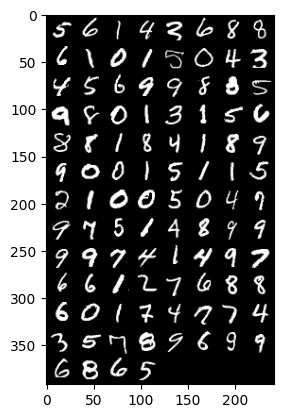

tensor([5, 6, 1, 4, 3, 6, 8, 8, 6, 1, 0, 1, 5, 0, 4, 3, 4, 5, 6, 9, 9, 8, 3, 5,
        9, 8, 0, 1, 3, 1, 5, 6, 8, 8, 1, 8, 4, 1, 8, 9, 9, 0, 0, 1, 5, 1, 1, 5,
        2, 1, 0, 0, 5, 0, 4, 7, 9, 7, 5, 1, 4, 8, 9, 9, 9, 9, 7, 4, 1, 4, 9, 7,
        6, 6, 1, 2, 7, 6, 8, 8, 6, 0, 1, 7, 4, 7, 7, 4, 3, 5, 7, 8, 9, 6, 9, 9,
        6, 8, 6, 5])


In [4]:
## View Img
images, labels = next(iter(trainloader))

def showBatchImg(images):
    img = torchvision.utils.make_grid(images)         ## B x C x H x W: [4, 1, 28, 28] ==>  (C=3) x (H+padding) x (W*B): [3, 32, 122]
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  ## switch axis: [3, 32, 122] ==> (32, 122, 3) 
    plt.show()

showBatchImg(images)
print(labels)

In [5]:
images.shape

torch.Size([100, 1, 28, 28])

## Classifier Model

In [6]:
## Classifier Model -- input: 28*28*1

class Classifier_Net(nn.Module):
    def __init__(self,classNum):       ## define structure -- 注意，如果需要2个CovBlock，不能直接复用，要定义self.CovBlock1，self.CovBlock2
        super().__init__()
        self.CovBlock = nn.Sequential(
            nn.Conv2d(1,6,(5,5)),    ## 1*28*28  ==> 6*24*24 (kernel=5:28-5+1=24, stride=1: no change)  
            nn.MaxPool2d((2,2)),     ##          ==> 6*12*12
            nn.Conv2d(6,16,(5,5)),   ##          ==> 16*8*8    
            nn.Flatten(),
            nn.Linear(16*8*8,128),   ##          ==> 128             12800x8 and 1024x128
            nn.ReLU(),
            nn.Linear(128,classNum), ##          ==> classNum      128*10
            nn.ReLU()
        )
    def forward(self, x):       ## define forward path
        x = self.CovBlock(x) 
        # print(x.size())
        return x

model = Classifier_Net(10).to(device)
print(model)

Classifier_Net(
  (CovBlock): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=1024, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
    (7): ReLU()
  )
)


In [7]:
def train(dataloader, model, loss_fn, optimizer):
    lossSum = 0
    model.train()                                    ### set training mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        lossSum += loss.item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avgTrainingLoss = lossSum/len(dataloader)
    return avgTrainingLoss


def test(dataloader, model, loss_fn):
    lossSum = 0
    correctSum = 0
    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            lossSum += loss_fn(pred, y).item()
            correctSum += (pred.argmax(1) == y).type(torch.float).sum().item()
    avgTestingLoss = lossSum/len(dataloader)             ## /num_batches
    avgTestingAcc  = correctSum/len(dataloader.dataset)  ## /size
    return avgTestingLoss,avgTestingAcc

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 20
for t in range(epochs):
    avgTrainingLoss = train(trainloader, model, loss_fn, optimizer)
    avgTestingLoss,avgTestingAcc = test(testloader, model, loss_fn)
    print(f'Epoch {t+1}----Testing Acc:: {avgTestingAcc:>7f}') 

Epoch 1----Testing Acc:: 0.221700
Epoch 2----Testing Acc:: 0.440600
Epoch 3----Testing Acc:: 0.584600
Epoch 4----Testing Acc:: 0.629800
Epoch 5----Testing Acc:: 0.659800
Epoch 6----Testing Acc:: 0.719200
Epoch 7----Testing Acc:: 0.754800
Epoch 8----Testing Acc:: 0.778100
Epoch 9----Testing Acc:: 0.791200
Epoch 10----Testing Acc:: 0.799900
Epoch 11----Testing Acc:: 0.805000
Epoch 12----Testing Acc:: 0.811300
Epoch 13----Testing Acc:: 0.815100
Epoch 14----Testing Acc:: 0.816700
Epoch 15----Testing Acc:: 0.819500
Epoch 16----Testing Acc:: 0.823300
Epoch 17----Testing Acc:: 0.825000
Epoch 18----Testing Acc:: 0.826900
Epoch 19----Testing Acc:: 0.829500
Epoch 20----Testing Acc:: 0.830800


In [9]:
## Use Model

images, labels = next(iter(trainloader))
X= images[:10].to(device)
pred = model(X)

print(pred.argmax(1))
print(labels[:10])

tensor([6, 9, 0, 8, 3, 6, 6, 4, 4, 9])
tensor([6, 9, 7, 8, 2, 6, 6, 4, 4, 9])
